# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [1]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-06-20 19:28:49--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.16
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  13.8MB/s    in 1m 50s  

2022-06-20 19:30:40 (9.77 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [4]:
session = sagemaker.Session()

# bucket= session.default_bucket()
bucket = 'udacity-deep-learning-project3'
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

#Alternative:

# session = sagemaker.session.Session()
# bucket = session.default_bucket()
# inputs = session.upload_data(path='dogImages', bucket=bucket, key_prefix='dogImages')

Default Bucket: udacity-deep-learning-project3
AWS Region: us-east-1
RoleArn: arn:aws:iam::678464824168:role/SageMaker-For-DeepRacer-S-SageMakerNotebookInstanc-1BG92H9F386X
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://udacity-deep-learning-project3/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg to s3://udacity-deep-learning-project3/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg to s3://udacity-deep-learning-project3/dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://udacity-deep-learning-project3/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg to s3://udacity-deep-learning-project3/dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg
upload: dogImages/test/001

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [55]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    'epochs': IntegerParameter(2, 5)
#     "batch-size": CategoricalParameter([32, 64, 128, 256, 512])
#     "epochs": IntegerParameter(2, 4)
}

In [57]:
#TODO: Create estimators for your HPs

from sagemaker.pytorch.estimator import PyTorch
from sagemaker.pytorch.model import PyTorchModel
session = sagemaker.session.Session()
bucket = session.default_bucket()
role = get_execution_role()

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p2.xlarge"
#     instance_type="ml.g4dn.xlarge"
)
# TODO: Your estimator here

objective_metric_name = "average test loss"
objective_type = "Minimize"

# metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=1,
    objective_type=objective_type,
)
# TODO: Your HP tuner here

In [ ]:
# TODO: Fit your HP Tuner
# TODO: Remember to include your data channels
input_data = 's3://udacity-deep-learning-project3/dogImages/'
tuner.fit(
    {
    'train': input_data + 'train',
    'test': input_data + 'test',
    'val': input_data + 'valid'
    }
 ) 

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [60]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() 

# best_job = tuner.best_training_job()
best_estimator._current_job_name

#TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-06-21 10:53:37 Starting - Preparing the instances for training
2022-06-21 10:53:37 Downloading - Downloading input data
2022-06-21 10:53:37 Training - Training image download completed. Training in progress.
2022-06-21 10:53:37 Uploading - Uploading generated training model
2022-06-21 10:53:37 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'epochs': '3',
 'lr': '0.0017089206069718153',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-06-21-10-41-16-605"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-06-21-10-41-16-605/source/sourcedir.tar.gz"'}

In [61]:
best_job = tuner.best_training_job()
best_job

'pytorch-training-220621-1041-001-f03cb11c'

In [72]:
# best_batch_size = int(best_estimator.hyperparameters()['batch-size'].replace('"', '')) #somehow it addes weird "" so we remove it
best_lr = float(best_estimator.hyperparameters()['lr'])
best_epoch = int(best_estimator.hyperparameters()['epochs'])

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [86]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
# debugger_config = DebuggerHookConfig(
#     hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
# )

# debugger configuration above was overwritten by profiler config and giving only 3 values for the plot
# due to interval of 500

collection_configs = [
    CollectionConfig(
        name="custom_losses",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "50",
            "eval.save_interval": "10"
        }
    )
]

debugger_config = DebuggerHookConfig(
    collection_configs=collection_configs
)

hyperparameters = {"lr": best_lr, "epochs": best_epoch}

# "batch-size": best_batch_size

rules = [
#     Rule.sagemaker(rule_configs.loss_not_decreasing()),
#     ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
#     ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
#     Rule.sagemaker(rule_configs.vanishing_gradient()),
#     Rule.sagemaker(rule_configs.overfit()),
#     Rule.sagemaker(rule_configs.overtraining()),
#     Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

In [87]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.p2.xlarge",
#     instance_type="ml.g4dn.xlarge",    
#     source_dir="scripts",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)
# TODO: Your estimator here

In [88]:
input_data = 's3://udacity-deep-learning-project3/dogImages/'
estimator.fit(
    {
    'train': input_data + 'train',
    'test': input_data + 'test',
    'val': input_data + 'valid'
    },
 )

2022-06-21 12:00:35 Starting - Starting the training job...
2022-06-21 12:01:03 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
............
2022-06-21 12:03:00 Downloading - Downloading input data............
2022-06-21 12:05:01 Training - Downloading the training image........................
2022-06-21 12:09:06 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-06-21 12:09:10,878 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-06-21 12:09:10,907 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-06-21 12:09:10,921 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-06-21 12:09:11,739 sagemaker-training-toolkit INFO     Invoking user script
Training

In [66]:
# job_name = 'pytorch-training-2022-06-21-10-09-18-189'
# client = estimator.sagemaker_session.sagemaker_client
# description = client.describe_training_job(TrainingJobName=job_name)
# region = session.boto_region_name

# trial = create_trial(estimator.latest_job_debugger_artifacts_path())

# trial.tensor_names()

In [89]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
region = session.boto_region_name

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2022-06-21 12:16:45.277 ip-172-16-112-212:17890 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-06-21-12-00-35-275/debug-output


['CrossEntropyLoss_output_0']

In [90]:
trial.tensor('CrossEntropyLoss_output_0').values()

{0: array(4.9516997, dtype=float32),
 100: array(4.952166, dtype=float32),
 200: array(4.7324533, dtype=float32),
 300: array(4.638015, dtype=float32),
 400: array(4.3078866, dtype=float32),
 500: array(4.0535398, dtype=float32),
 600: array(4.058694, dtype=float32),
 668: array(3.783338, dtype=float32),
 678: array(2.7856188, dtype=float32),
 688: array(4.076688, dtype=float32),
 698: array(3.9312286, dtype=float32),
 708: array(3.9981523, dtype=float32),
 718: array(4.2156034, dtype=float32),
 728: array(4.169474, dtype=float32),
 738: array(4.5623164, dtype=float32),
 748: array(4.674161, dtype=float32),
 758: array(4.117526, dtype=float32),
 768: array(3.4070492, dtype=float32),
 778: array(4.1697097, dtype=float32),
 788: array(3.2432473, dtype=float32),
 798: array(4.170407, dtype=float32),
 808: array(3.8169894, dtype=float32),
 818: array(3.9534104, dtype=float32),
 828: array(3.965863, dtype=float32)}

7
17
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


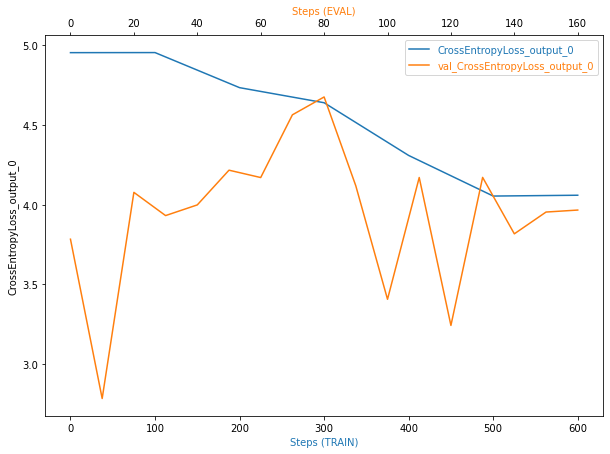

In [91]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [92]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=['total']
)

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-678464824168/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-06-21-12-00-35-275/profiler-output


Profiler data from system is available
[2022-06-21 12:17:38.091 ip-172-16-112-212:17890 INFO metrics_reader_base.py:134] Getting 11 event files
select events:['total']
select dimensions:['CPU'

In [93]:
# TODO: Display the profiler output

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-06-21-12-00-35-275/rule-output


In [94]:
! aws s3 ls {rule_output_path} --recursive

2022-06-21 12:14:10     403336 pytorch-training-2022-06-21-12-00-35-275/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-06-21 12:14:10     255698 pytorch-training-2022-06-21-12-00-35-275/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-06-21 12:14:05        192 pytorch-training-2022-06-21-12-00-35-275/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-06-21 12:14:05      18562 pytorch-training-2022-06-21-12-00-35-275/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-06-21 12:14:05       2042 pytorch-training-2022-06-21-12-00-35-275/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-06-21 12:14:05        130 pytorch-training-2022-06-21-12-00-35-275/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-06-21 12:14:05      11110 pytorch-training-2022-06-21-12-00-35-275/rule-output/ProfilerReport/profiler-output/profiler-re

In [95]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-06-21-12-00-35-275/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-06-21-12-00-35-275/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-06-21-12-00-35-275/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-06-21-12-00-35-275/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-06-21-

In [96]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [98]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [109]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor

jpeg_serializer = IdentitySerializer("image/jpeg")
json_deserializer = JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

role = get_execution_role()
# model_location = estimator.model_data
model_location = 's3://sagemaker-us-east-1-678464824168/pytorch-training-2022-06-21-12-00-35-275/source/sourcedir.tar.gz'

pytorch_model = PyTorchModel(
    model_data=model_location,
    role = role,
    entry_point='inference.py',
    py_version='py36',
    framework_version='1.8',
    predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
#     instance_type="ml.p2.xlarge"
)

-------!

In [103]:
# TODO: Deploy your model to an endpoint

# predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

In [110]:
file = 'dogImages/test/124.Poodle/Poodle_07910.jpg'
image = open(file, 'rb').read()
response = predictor.predict(data=image)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2022-06-21-13-03-14-037 in account 678464824168 for more information.

The dog photo used to do the prediction is:


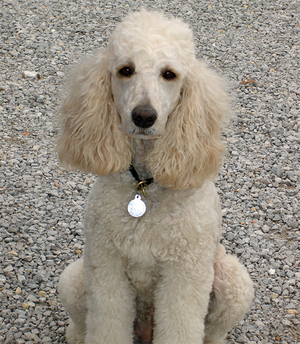

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2022-06-21-13-03-14-037 in account 678464824168 for more information.

In [111]:
# TODO: Run an prediction on the endpoint

# file = 'dogImages/test/124.Poodle/Poodle_07910.jpg'
# image = open(file, 'rb').read()
# response = predictor.predict(data=image)

from PIL import Image

files = [
    'dogImages/test/124.Poodle/Poodle_07949.jpg', 
    'dogImages/test/123.Pomeranian/Pomeranian_07858.jpg',
    'dogImages/test/125.Portuguese_water_dog/Portuguese_water_dog_07971.jpg',
    ]
    
for file in files:
    # Getting labels
    target_str = 'test/'
    in_pos = file.index(target_str) + len(target_str)
    label = int(file[in_pos:in_pos+3])
    
    # Displaying image to be predicted
    img = Image.open(file)
    print('The dog photo used to do the prediction is:')
    display(img)
    
    # Querying endpoint
    image = open(file, 'rb').read()
    response = predictor.predict(image, initial_args={'ContentType':'image/jpeg'})
    prediction = np.argmax(response[0]) + 1    
    
    print(f'The label of the image is {label}')
    print(f'The prediction given by the machine learning model is {prediction}\n')

# image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
# response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()